<h1 style="color:red; font-family: 'Helvetica Neue', sans-serif; font-size:40px; text-align: center; font-weight:bold; font-style:italic">Rice Leaf Disease: Image Classification</h1>

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Importing Libraries</h1>

In [1]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt 
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras tuner
import keras_tuner
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

#transfer learning
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.xception import Xception

#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

we are currently using tensorflow version 2.10.0


<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Setting up an environment</h1>

In [2]:
input_shape_2D=(224,224)
input_shape_3D= (224,224,3)
seed=1
batch_size=32
epochs=30
stopper=EarlyStopping(patience=5)

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Uploading image dataset</h1>



In [3]:
#loading image data
data_ds= tf.keras.utils.image_dataset_from_directory(
    directory='Data_Rice_Deseases_5class/',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None, 
    image_size=input_shape_2D,
    seed=seed
)

Found 1809 files belonging to 5 classes.


In [4]:
#class labels
class_names = data_ds.class_names

print("Class Names:", class_names)

Class Names: ['Bacterial Leaf Blight', 'Brown Spot', 'Healthy', 'Leaf Blast', 'Narrow Brown']


In [5]:
def show_images(images, labels):
    fig, axes = plt.subplots(8, 4, figsize=(10, 10))
    axes = axes.flatten()
    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img.numpy().astype("uint8"))
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

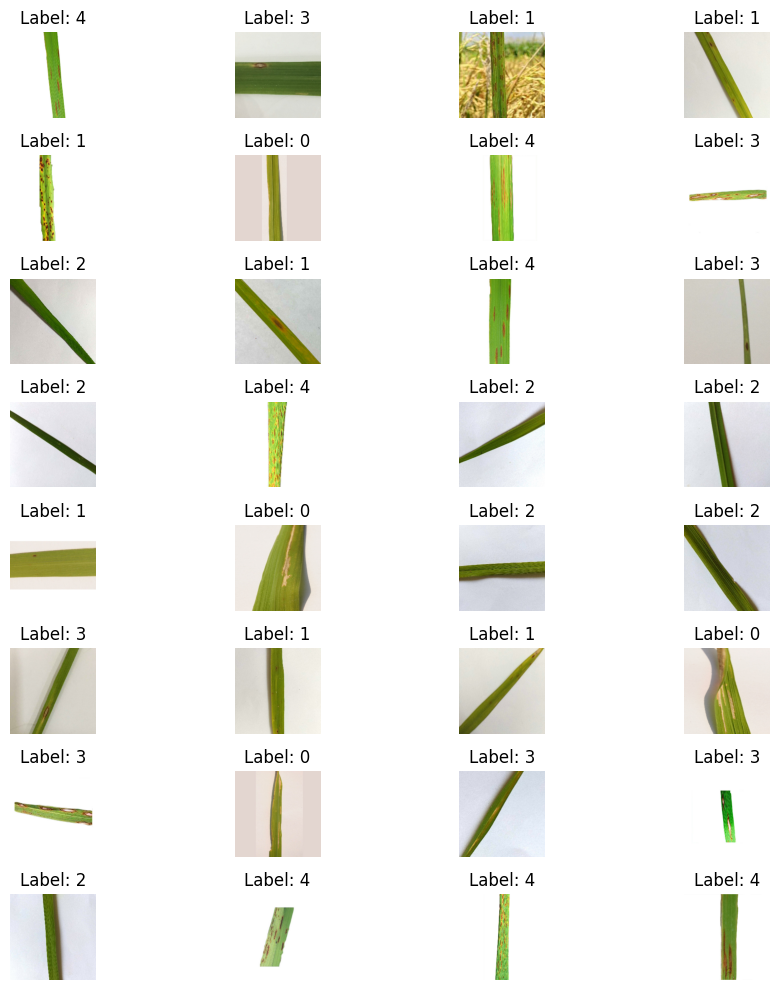

In [6]:
#displaying image batch of 32
batched_ds = data_ds.batch(batch_size)

batch = next(iter(batched_ds))
images, labels = batch

images, labels = next(iter(batched_ds))
show_images(images, labels)

Great! we have now loaded the image data in the notebook. Let's quickly separate images and labels and store them into X and y respectively

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Data Processing</h1>

In [5]:
X=[]
y= []

for image, label in data_ds.batch(119):
  for img, lab in zip(image, label):
    X.append(img)
    y.append(lab.numpy())


In [6]:
# converting to numpy array
X= np.array(X)
y= np.array(y)

In [7]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

# Normalisation

In [8]:
X_train = X_train/255
X_test = X_test/255

In [9]:
print("shape of X_train_scaled:", X_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of X_test_scaled:", X_test.shape)
print("shape of y_test:", y_test.shape)

shape of X_train_scaled: (1356, 224, 224, 3)
shape of y_train: (1356,)
shape of X_test_scaled: (453, 224, 224, 3)
shape of y_test: (453,)


# Encoding

In [10]:
y_train = to_categorical(y_train, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">CNN Architecture</h1>

In [22]:
own_model=Sequential()

# adding first convloutional layer
own_model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape_3D))
own_model.add(MaxPooling2D(pool_size=(2,2)))

# adding second convloutional layer
own_model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
own_model.add(MaxPooling2D(pool_size=(2,2)))

# adding third convloutional layer
own_model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
own_model.add(MaxPooling2D(pool_size=(2,2)))

# adding flatten layer
own_model.add(Flatten())

# adding fully connected layers
own_model.add(Dense(512, activation='relu'))

#adding output layer : number of classes are 3
own_model.add(Dense(5, activation='softmax'))


In [23]:
# looking at the architecture summary
own_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 128)     

In [37]:
# compiling model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
own_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Fit the model
history=own_model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=100)

Epoch 1/100
43/43 [==============================] - 5s 45ms/step - loss: 1.9343 - accuracy: 0.4078 - val_loss: 1.1708 - val_accuracy: 0.5099
Epoch 2/100
43/43 [==============================] - 1s 35ms/step - loss: 0.9621 - accuracy: 0.6150 - val_loss: 0.9156 - val_accuracy: 0.6291
Epoch 3/100
43/43 [==============================] - 1s 35ms/step - loss: 0.7274 - accuracy: 0.7131 - val_loss: 0.9286 - val_accuracy: 0.6424
Epoch 4/100
43/43 [==============================] - 1s 35ms/step - loss: 0.5675 - accuracy: 0.7891 - val_loss: 0.8928 - val_accuracy: 0.6490
Epoch 5/100
43/43 [==============================] - 2s 35ms/step - loss: 0.4160 - accuracy: 0.8370 - val_loss: 0.7922 - val_accuracy: 0.7174
Epoch 6/100
43/43 [==============================] - 1s 35ms/step - loss: 0.3768 - accuracy: 0.8591 - val_loss: 0.7303 - val_accuracy: 0.7241
Epoch 7/100
43/43 [==============================] - 1s 35ms/step - loss: 0.2936 - accuracy: 0.8842 - val_loss: 0.6975 - val_accuracy: 0.7528
Epoch 

In [15]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

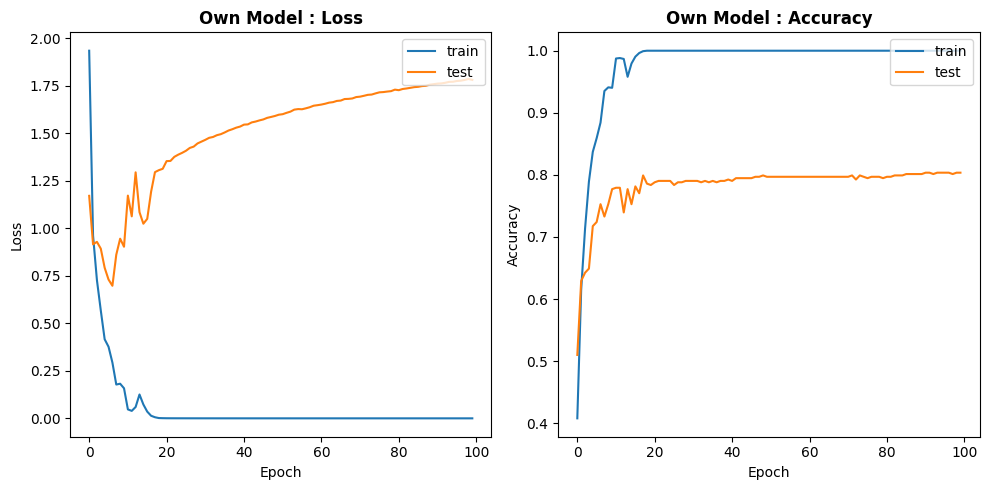

In [16]:
plot_performance(model_name= 'Own Model',
                 acc=history.history['accuracy'], 
                 val_acc=history.history['val_accuracy'],
                 loss=history.history['loss'], 
                 val_loss=history.history['val_loss'])

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Data Augmentation</h1>

In [38]:
#creating image generator object
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

In [44]:
# training the model
checkpointer_OwnCNN_aug = ModelCheckpoint(filepath='ownCNN_aug.weights.best.hdf5', verbose=3, save_best_only=True)
aug_history= own_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//64, 
    epochs=300,
    callbacks=[checkpointer_OwnCNN_aug]
)

Epoch 1/300
21/21 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9899
Epoch 1: val_loss improved from inf to 0.47816, saving model to ownCNN_aug.weights.best.hdf5
21/21 [==============================] - 6s 278ms/step - loss: 0.0273 - accuracy: 0.9899 - val_loss: 0.4782 - val_accuracy: 0.9448
Epoch 2/300
21/21 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9946
Epoch 2: val_loss improved from 0.47816 to 0.44294, saving model to ownCNN_aug.weights.best.hdf5
21/21 [==============================] - 6s 276ms/step - loss: 0.0142 - accuracy: 0.9946 - val_loss: 0.4429 - val_accuracy: 0.9536
Epoch 3/300
21/21 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9977
Epoch 3: val_loss improved from 0.44294 to 0.43560, saving model to ownCNN_aug.weights.best.hdf5
21/21 [==============================] - 6s 277ms/step - loss: 0.0118 - accuracy: 0.9977 - val_loss: 0.4356 - val_accuracy: 0.9492
Epoch 4/300
21/21 [================

In [32]:
X_test.shape

(453, 224, 224, 3)

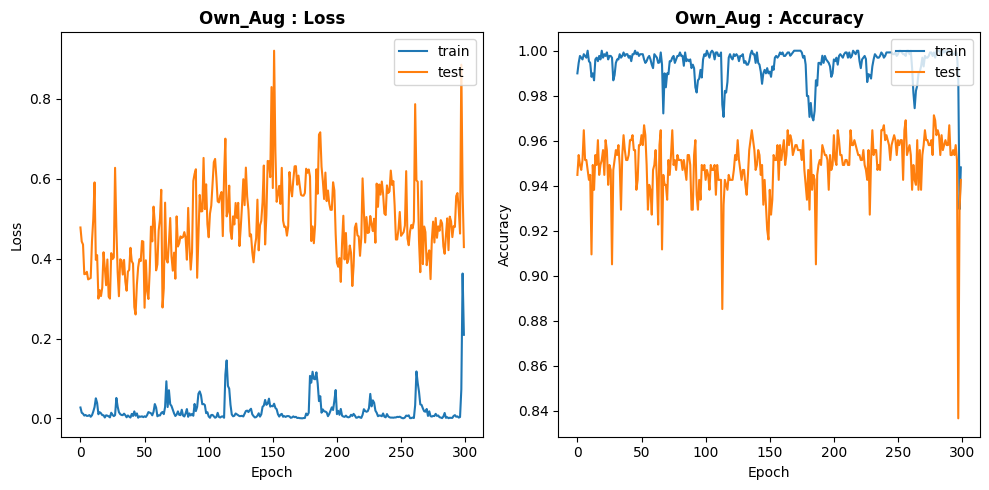

In [45]:
#visualising model performance
plot_performance(model_name='Own_Aug',
                  acc=aug_history.history['accuracy'], 
                 val_acc=aug_history.history['val_accuracy'],
                 loss=aug_history.history['loss'], 
                 val_loss=aug_history.history['val_loss'])

## VGG16

VGG16 is a deep convolutional neural network architecture proposed by the Visual Geometry Group at the University of Oxford. It was introduced in the 2014 ImageNet Large Scale Visual Recognition Challenge, where it achieved state-of-the-art performance on object recognition tasks. The architecture consists of 16 layers, including 13 convolutional layers and 3 fully connected layers, and has been widely used as a base model for transfer learning in various computer vision tasks.

In [41]:
vgg_base=VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape_3D,
)

#un-freezing last block of convolution layers
vgg_base.trainable=True
set_trainable=False

for layer in vgg_base.layers:
  if layer.name=='block5_conv1':
    set_trainable=True

  if set_trainable==True:
    layer.trainable=True
  else:
    layer.trainable=False

#building fully connected layers
vgg_model=Sequential()

vgg_model.add(vgg_base)
vgg_model.add(Flatten())

vgg_model.add(Dense(200, activation='relu'))

vgg_model.add(Dense(5, activation='softmax'))

#compiling 
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 200)               5017800   
                                                                 
 dense_5 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 19,733,493
Trainable params: 12,098,229
Non-trainable params: 7,635,264
_________________________________________________________________


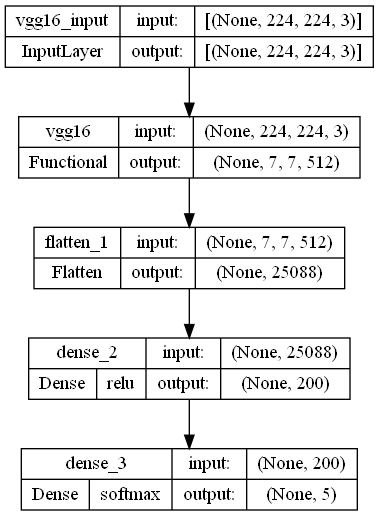

In [24]:
utils.plot_model(
    vgg_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    #show_trainable=True,
)

### Without Augmentation

In [25]:
#training
vgg_history=vgg_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs
)

Epoch 1/30
43/43 [==============================] - 11s 137ms/step - loss: 1.7891 - accuracy: 0.3621 - val_loss: 1.1860 - val_accuracy: 0.5342
Epoch 2/30
43/43 [==============================] - 4s 82ms/step - loss: 1.1780 - accuracy: 0.4941 - val_loss: 1.0328 - val_accuracy: 0.4923
Epoch 3/30
43/43 [==============================] - 4s 89ms/step - loss: 0.9603 - accuracy: 0.5826 - val_loss: 1.0129 - val_accuracy: 0.5872
Epoch 4/30
43/43 [==============================] - 4s 82ms/step - loss: 0.8076 - accuracy: 0.6512 - val_loss: 0.9387 - val_accuracy: 0.6424
Epoch 5/30
43/43 [==============================] - 4s 92ms/step - loss: 0.7121 - accuracy: 0.6851 - val_loss: 0.7406 - val_accuracy: 0.6424
Epoch 6/30
43/43 [==============================] - 4s 82ms/step - loss: 0.6507 - accuracy: 0.7028 - val_loss: 0.7548 - val_accuracy: 0.6954
Epoch 7/30
43/43 [==============================] - 4s 88ms/step - loss: 0.5734 - accuracy: 0.7493 - val_loss: 0.7468 - val_accuracy: 0.6909
Epoch 8/30


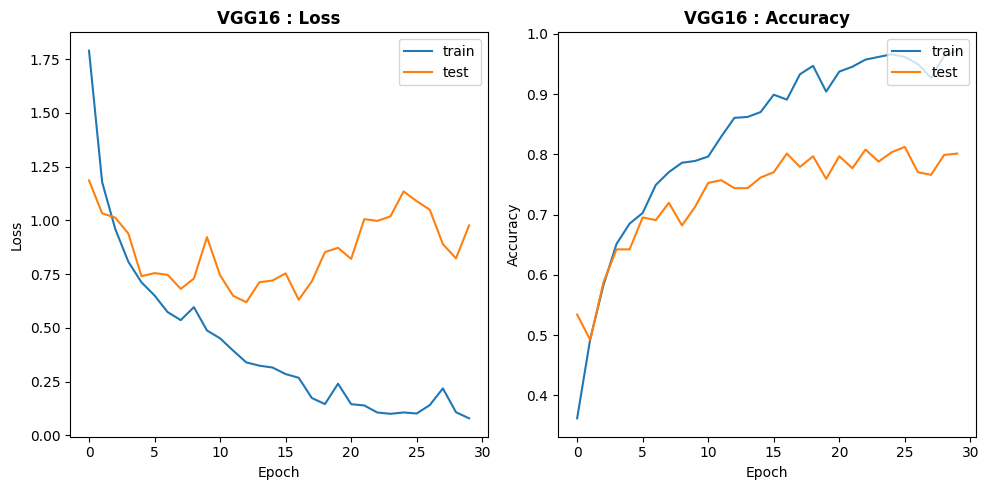

In [26]:
plot_performance(model_name='VGG16', 
                acc=vgg_history.history['accuracy'], 
                 val_acc=vgg_history.history['val_accuracy'],
                 loss=vgg_history.history['loss'], 
                 val_loss=vgg_history.history['val_loss'])

### With Augmentation

In [43]:
#training
vgg_history_aug=vgg_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//64,
    epochs=300
)

Epoch 1/300
21/21 [==============================] - 13s 427ms/step - loss: 2.5686 - accuracy: 0.2136 - val_loss: 1.6097 - val_accuracy: 0.1854
Epoch 2/300
21/21 [==============================] - 6s 269ms/step - loss: 1.6221 - accuracy: 0.2090 - val_loss: 1.6096 - val_accuracy: 0.1854
Epoch 3/300
21/21 [==============================] - 6s 281ms/step - loss: 1.6094 - accuracy: 0.2128 - val_loss: 1.6098 - val_accuracy: 0.1854
Epoch 4/300
21/21 [==============================] - 6s 267ms/step - loss: 1.6093 - accuracy: 0.2105 - val_loss: 1.6101 - val_accuracy: 0.1854
Epoch 5/300
21/21 [==============================] - 6s 267ms/step - loss: 1.6092 - accuracy: 0.2105 - val_loss: 1.6103 - val_accuracy: 0.1854
Epoch 6/300
21/21 [==============================] - 6s 269ms/step - loss: 1.6092 - accuracy: 0.2144 - val_loss: 1.6106 - val_accuracy: 0.1854
Epoch 7/300
21/21 [==============================] - 6s 271ms/step - loss: 1.6090 - accuracy: 0.2136 - val_loss: 1.6106 - val_accuracy: 0.185

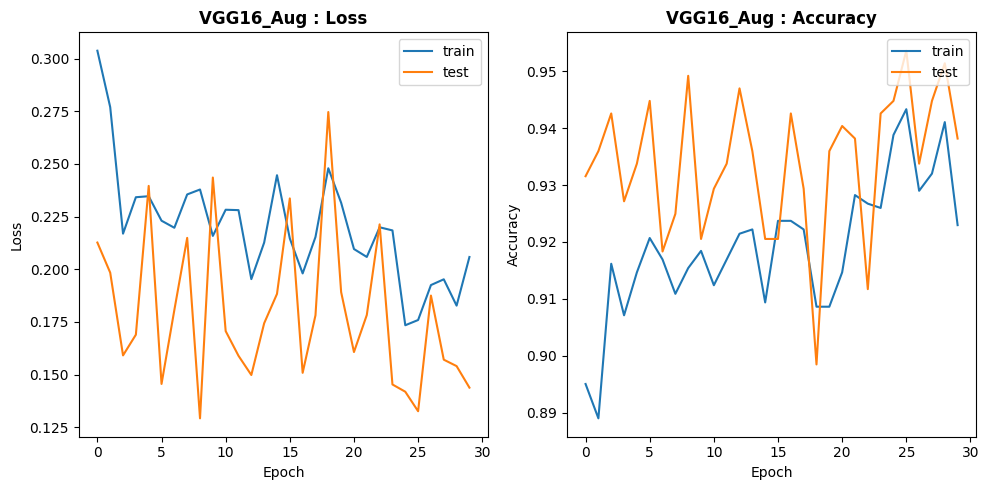

In [30]:
plot_performance(model_name='VGG16_Aug',
                  acc=vgg_history_aug.history['accuracy'], 
                 val_acc=vgg_history_aug.history['val_accuracy'],
                 loss=vgg_history_aug.history['loss'], 
                 val_loss=vgg_history_aug.history['val_loss'])

## InceptionV3

InceptionV3 is a deep convolutional neural network architecture that was developed by Google. It is known for its efficiency in training and accuracy in image classification tasks. The model uses a combination of convolutional layers with varying kernel sizes to capture features at different scales. InceptionV3 was the winner of the 2015 ImageNet Large Scale Visual Recognition Challenge.

In [31]:
inception_base=tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape_3D,
)

#unfreezing the convloution layers
inception_base.trainable=True
set_trainable=False

for layer in inception_base.layers:
  if layer.name=='mixed9_0':
    set_trainable=True
  
  if set_trainable==True:
    layer.trainable=True

  else:
    layer.trainable=False


# building fully connected layers
inception_model= Sequential()

inception_model.add(inception_base)
inception_model.add(Flatten())

inception_model.add(Dense(128, activation='relu'))
inception_model.add(Dense(5, activation='softmax'))


#compiling 
inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

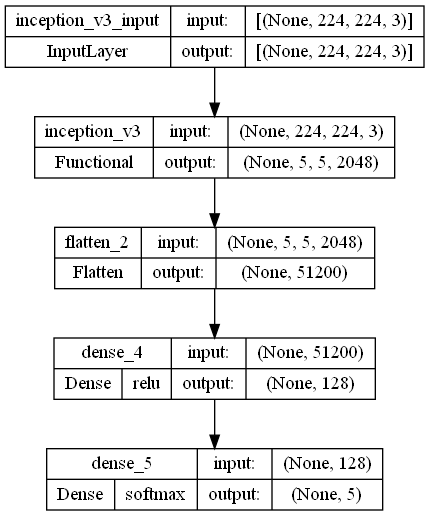

In [32]:
tf.keras.utils.plot_model(
    inception_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    #show_trainable=True,
)

#### Without Augmentation

In [33]:
#training model
checkpointer_inception = ModelCheckpoint(filepath='inception.weights.best.hdf5', verbose=3, save_best_only=True)

inception_history= inception_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[checkpointer_inception]
)

Epoch 1/30
43/43 [==============================] - ETA: 0s - loss: 1.6397 - accuracy: 0.7316
Epoch 1: val_loss improved from inf to 1.18566, saving model to inception.weights.best.hdf5
43/43 [==============================] - 6s 102ms/step - loss: 1.6397 - accuracy: 0.7316 - val_loss: 1.1857 - val_accuracy: 0.8675
Epoch 2/30
42/43 [============================>.] - ETA: 0s - loss: 0.2378 - accuracy: 0.9263
Epoch 2: val_loss improved from 1.18566 to 0.37986, saving model to inception.weights.best.hdf5
43/43 [==============================] - 3s 74ms/step - loss: 0.2375 - accuracy: 0.9263 - val_loss: 0.3799 - val_accuracy: 0.9227
Epoch 3/30
43/43 [==============================] - ETA: 0s - loss: 0.1025 - accuracy: 0.9683
Epoch 3: val_loss did not improve from 0.37986
43/43 [==============================] - 3s 66ms/step - loss: 0.1025 - accuracy: 0.9683 - val_loss: 0.4220 - val_accuracy: 0.9183
Epoch 4/30
42/43 [============================>.] - ETA: 0s - loss: 0.0754 - accuracy: 0.978

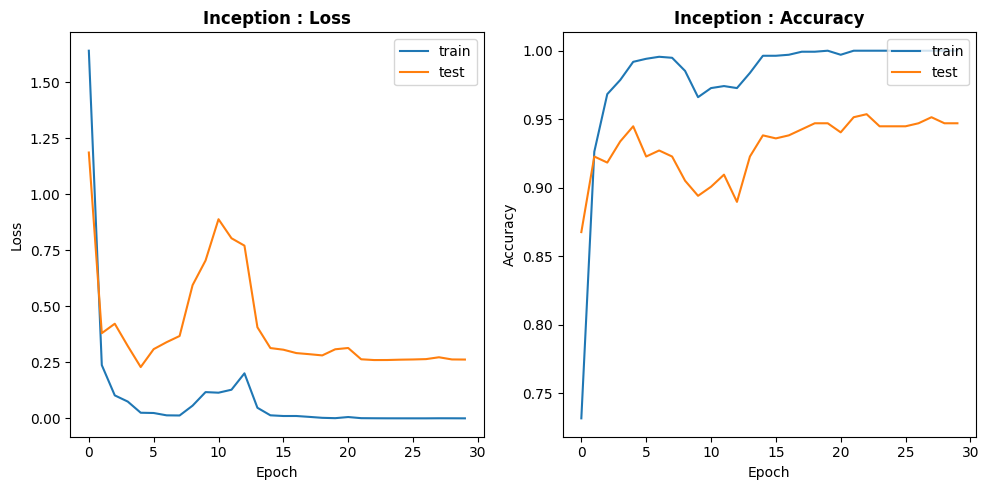

In [35]:
plot_performance(model_name='Inception',
                acc=inception_history.history['accuracy'], 
                 val_acc=inception_history.history['val_accuracy'],
                 loss=inception_history.history['loss'], 
                 val_loss=inception_history.history['val_loss'])

#### With Augmentation

In [36]:
#training model
checkpointer_inception_aug = ModelCheckpoint(filepath='inception_aug.weights.best.hdf5', verbose=3, save_best_only=True)

inception_history_aug= inception_model.fit(
    datagen.flow(X_train,y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs,
    callbacks=[checkpointer_inception_aug]
)

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 0.7377 - accuracy: 0.7832
Epoch 1: val_loss improved from inf to 0.45118, saving model to inception_aug.weights.best.hdf5
42/42 [==============================] - 8s 157ms/step - loss: 0.7377 - accuracy: 0.7832 - val_loss: 0.4512 - val_accuracy: 0.8565
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 0.5228 - accuracy: 0.8248
Epoch 2: val_loss improved from 0.45118 to 0.39184, saving model to inception_aug.weights.best.hdf5
42/42 [==============================] - 6s 153ms/step - loss: 0.5228 - accuracy: 0.8248 - val_loss: 0.3918 - val_accuracy: 0.8985
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 0.4261 - accuracy: 0.8588
Epoch 3: val_loss improved from 0.39184 to 0.28785, saving model to inception_aug.weights.best.hdf5
42/42 [==============================] - 6s 153ms/step - loss: 0.4261 - accuracy: 0.8588 - val_loss: 0.2879 - val_accuracy: 0.8962
Epoch 4/30
42/42 [===========

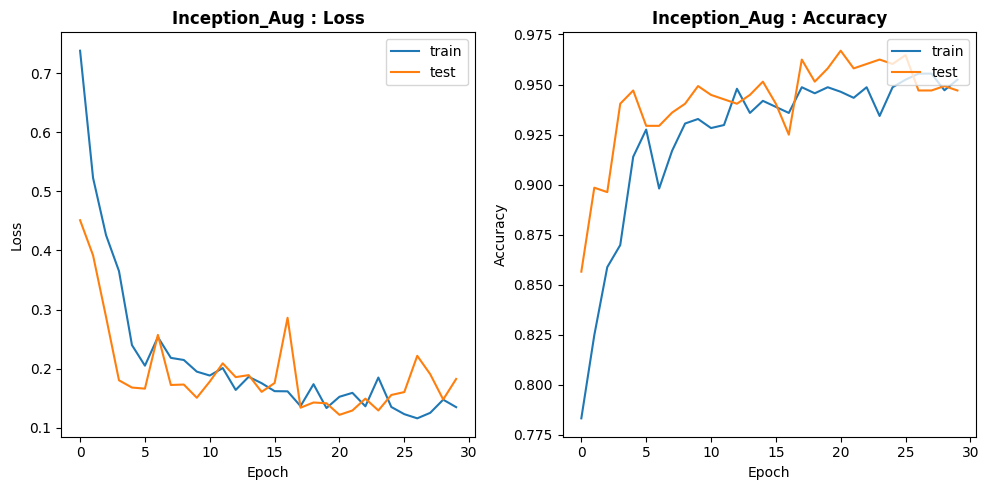

In [37]:
plot_performance(model_name='Inception_Aug',
                acc=inception_history_aug.history['accuracy'], 
                 val_acc=inception_history_aug.history['val_accuracy'],
                 loss=inception_history_aug.history['loss'], 
                 val_loss=inception_history_aug.history['val_loss'])

## ResNET

ResNet, short for Residual Network, is a deep neural network architecture that was introduced by Kaiming He et al. in 2015. ResNet's unique feature is the use of residual connections, which allow for the training of much deeper neural networks without suffering from the problem of vanishing gradients. This makes ResNet especially well-suited for image recognition tasks.

In [38]:
resnet_base=ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape_3D
)

resnet_base.trainable=True
set_trainable=False

for layer in resnet_base.layers:
  if layer.name=='conv5_block1_preact_bn':
    set_trainable=True

  if set_trainable==True:
    layer.trainable=True
  else:
    layer.trainable=False

#builing fully connected layers
resnet_model=Sequential()

resnet_model.add(resnet_base)
resnet_model.add(Flatten())

resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(5, activation='softmax'))

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

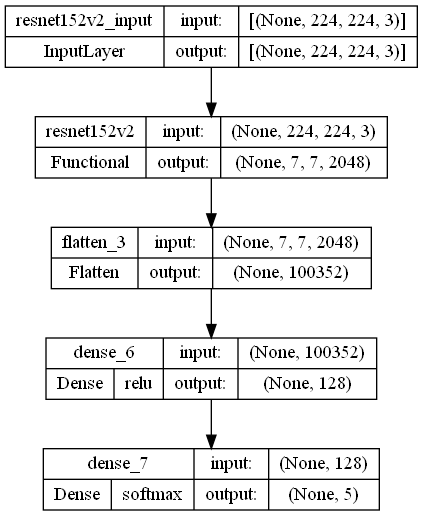

In [39]:
tf.keras.utils.plot_model(
    resnet_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    #show_trainable=True,
)

#### Without Augmentation

In [40]:
resnet_history=resnet_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs
)

Epoch 1/30
43/43 [==============================] - 11s 169ms/step - loss: 1.5354 - accuracy: 0.6563 - val_loss: 40.0326 - val_accuracy: 0.3466
Epoch 2/30
43/43 [==============================] - 6s 137ms/step - loss: 0.4338 - accuracy: 0.8650 - val_loss: 17.2685 - val_accuracy: 0.4614
Epoch 3/30
43/43 [==============================] - 6s 130ms/step - loss: 0.2672 - accuracy: 0.9240 - val_loss: 38.1586 - val_accuracy: 0.4437
Epoch 4/30
43/43 [==============================] - 6s 136ms/step - loss: 0.2494 - accuracy: 0.9329 - val_loss: 172.9965 - val_accuracy: 0.4879
Epoch 5/30
43/43 [==============================] - 6s 132ms/step - loss: 0.1588 - accuracy: 0.9617 - val_loss: 3.6702 - val_accuracy: 0.8631
Epoch 6/30
43/43 [==============================] - 6s 132ms/step - loss: 0.0696 - accuracy: 0.9830 - val_loss: 0.5514 - val_accuracy: 0.9051
Epoch 7/30
43/43 [==============================] - 6s 138ms/step - loss: 0.0754 - accuracy: 0.9808 - val_loss: 0.5542 - val_accuracy: 0.9051


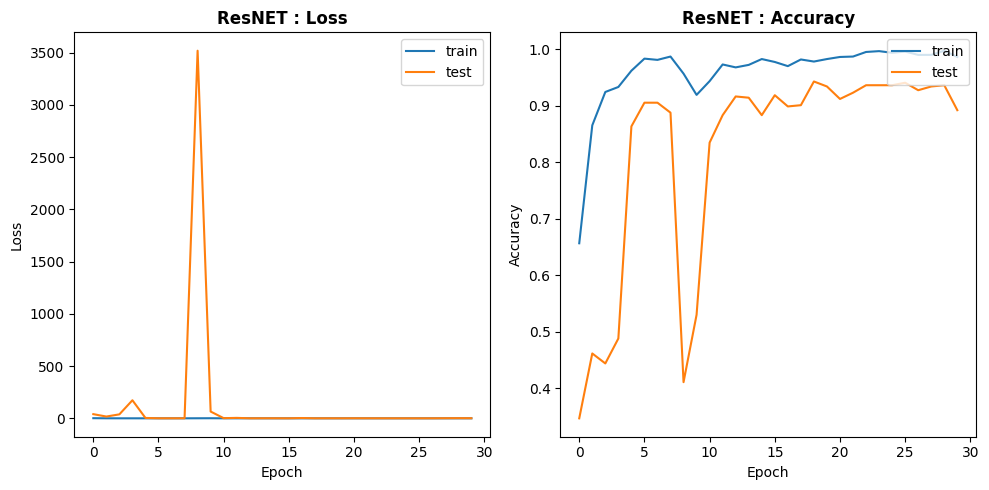

In [41]:
plot_performance(model_name='ResNET',
                acc=resnet_history.history['accuracy'], 
                 val_acc=resnet_history.history['val_accuracy'],
                 loss=resnet_history.history['loss'], 
                 val_loss=resnet_history.history['val_loss'])

#### With Augmentation

In [42]:
resnet_history_aug=resnet_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs
)

Epoch 1/30
42/42 [==============================] - 10s 179ms/step - loss: 1.7565 - accuracy: 0.7364 - val_loss: 4.2782 - val_accuracy: 0.3642
Epoch 2/30
42/42 [==============================] - 7s 178ms/step - loss: 0.7867 - accuracy: 0.7183 - val_loss: 1.0743 - val_accuracy: 0.5607
Epoch 3/30
42/42 [==============================] - 7s 171ms/step - loss: 0.5794 - accuracy: 0.7878 - val_loss: 0.6996 - val_accuracy: 0.7726
Epoch 4/30
42/42 [==============================] - 7s 175ms/step - loss: 0.4674 - accuracy: 0.8263 - val_loss: 0.3882 - val_accuracy: 0.8786
Epoch 5/30
42/42 [==============================] - 7s 178ms/step - loss: 0.4696 - accuracy: 0.8429 - val_loss: 0.2170 - val_accuracy: 0.9272
Epoch 6/30
42/42 [==============================] - 8s 178ms/step - loss: 0.3835 - accuracy: 0.8656 - val_loss: 0.2395 - val_accuracy: 0.9294
Epoch 7/30
42/42 [==============================] - 7s 177ms/step - loss: 0.6206 - accuracy: 0.8678 - val_loss: 0.8881 - val_accuracy: 0.7152
Epoch

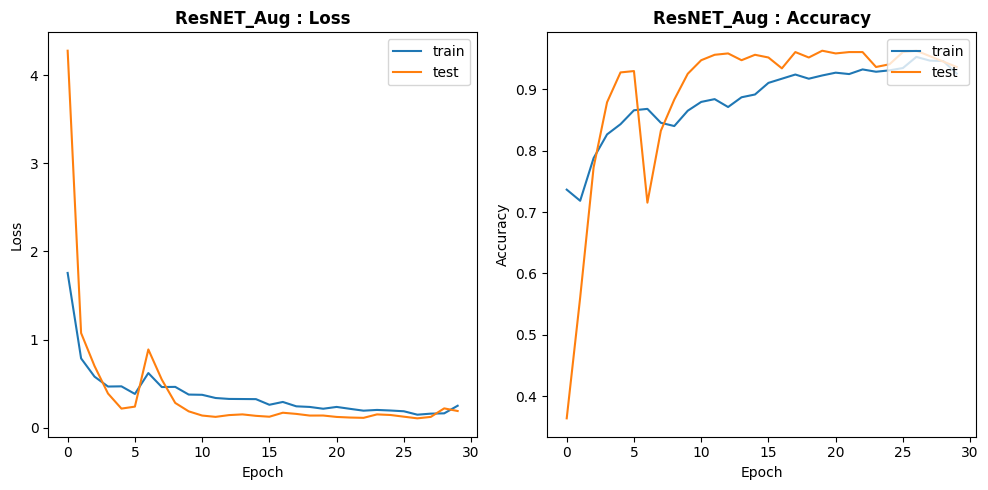

In [43]:
plot_performance(model_name='ResNET_Aug',
                acc=resnet_history_aug.history['accuracy'], 
                 val_acc=resnet_history_aug.history['val_accuracy'],
                 loss=resnet_history_aug.history['loss'], 
                 val_loss=resnet_history_aug.history['val_loss'])

## Xception

Xception is a deep neural network architecture proposed by Google researchers in 2016. It is an extension of the Inception architecture that replaces the standard Inception modules with depthwise separable convolutions, which are computationally efficient and lead to improved performance. Xception has achieved state-of-the-art results on various computer vision tasks and is commonly used in transfer learning applications.

In [21]:
xception_base= Xception(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape_3D
)

xception_base.trainable=True
set_trainable=False

for layer in xception_base.layers:
  if layer.name=='add_8':
    set_trainable=True

  if set_trainable==True:
    layer.trainable=True
  else:
    layer.trainable=False

#building fully connected layers
xception_model=Sequential()

xception_model.add(xception_base)
xception_model.add(Flatten())

xception_model.add(Dense(128, activation='relu'))
xception_model.add(Dense(5, activation='softmax'))

xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

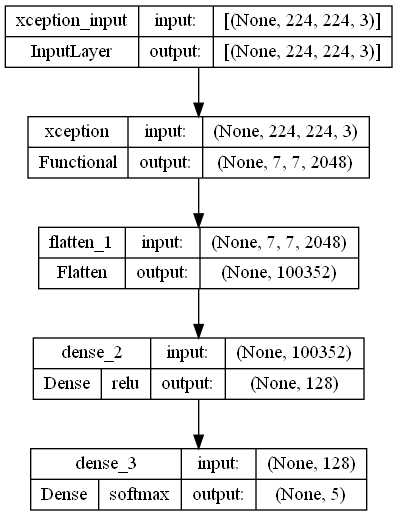

In [22]:
tf.keras.utils.plot_model(
    xception_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    #show_trainable=True,
)

#### Without Augmentation

In [46]:
#training model
checkpointer_xception = ModelCheckpoint(filepath='xception.weights.best.hdf5', verbose=3, save_best_only=True)

xception_history=xception_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    callbacks=[checkpointer_xception]
)

Epoch 1/30
43/43 [==============================] - ETA: 0s - loss: 1.5522 - accuracy: 0.3525
Epoch 1: val_loss improved from inf to 3.43819, saving model to xception.weights.best.hdf5
43/43 [==============================] - 6s 103ms/step - loss: 1.5522 - accuracy: 0.3525 - val_loss: 3.4382 - val_accuracy: 0.3775
Epoch 2/30
43/43 [==============================] - ETA: 0s - loss: 0.6988 - accuracy: 0.7625
Epoch 2: val_loss improved from 3.43819 to 1.40071, saving model to xception.weights.best.hdf5
43/43 [==============================] - 4s 92ms/step - loss: 0.6988 - accuracy: 0.7625 - val_loss: 1.4007 - val_accuracy: 0.7241
Epoch 3/30
42/43 [============================>.] - ETA: 0s - loss: 0.3662 - accuracy: 0.8787
Epoch 3: val_loss improved from 1.40071 to 0.63694, saving model to xception.weights.best.hdf5
43/43 [==============================] - 4s 89ms/step - loss: 0.3632 - accuracy: 0.8798 - val_loss: 0.6369 - val_accuracy: 0.8433
Epoch 4/30
42/43 [============================

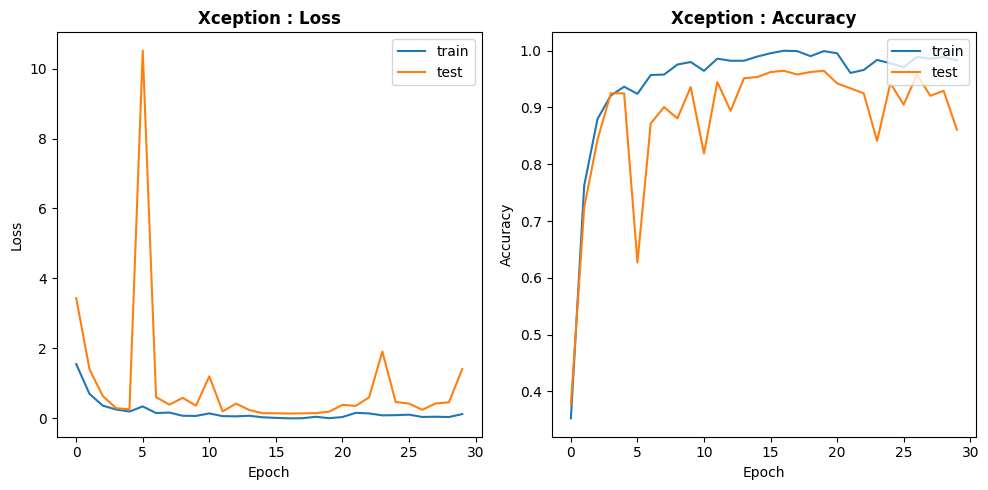

In [47]:
plot_performance(model_name='Xception',
                acc=xception_history.history['accuracy'], 
                 val_acc=xception_history.history['val_accuracy'],
                 loss=xception_history.history['loss'], 
                 val_loss=xception_history.history['val_loss'])

#### With Augmentation

In [23]:
checkpointer_xception_aug = ModelCheckpoint(filepath='xception_aug.weights.best.hdf5', verbose=3, save_best_only=True)

xception_history_aug=xception_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs,
    callbacks=[checkpointer_xception_aug]
)

NameError: name 'datagen' is not defined

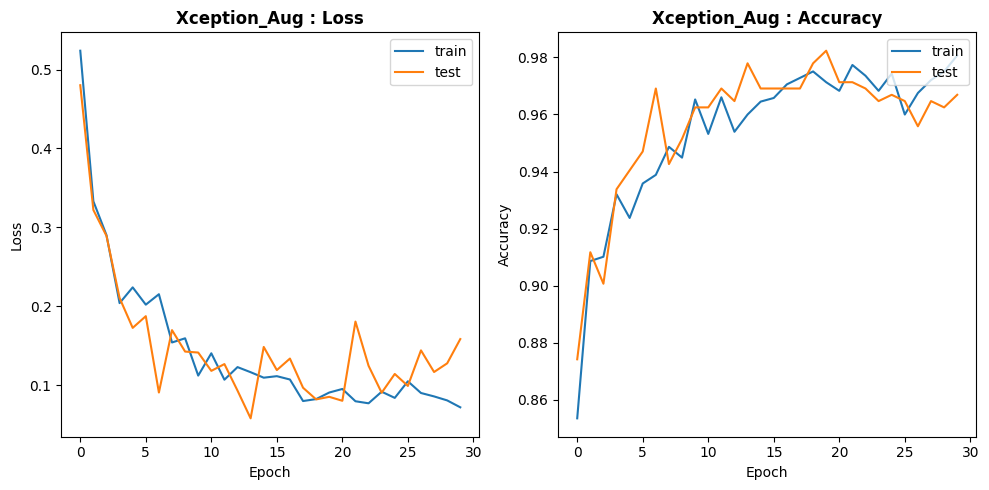

In [49]:
plot_performance(model_name='Xception_Aug',
                acc=xception_history_aug.history['accuracy'], 
                 val_acc=xception_history_aug.history['val_accuracy'],
                 loss=xception_history_aug.history['loss'], 
                 val_loss=xception_history_aug.history['val_loss'])

# Model Comparision and Analysis

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

In [79]:
models=pd.read_excel('model_comparision.xlsx', sheet_name='Data')
aug_models=pd.read_excel('model_comparision.xlsx', sheet_name='Augmentation')

In [80]:
models= models.merge(aug_models, on='model', suffixes=['', '_aug'])

In [83]:
models.loc[3, 'val_loss_aug']=7    #reason provided below
models

,model,loss,val_loss,acc,val_acc,time_ms,loss_aug,val_loss_aug,acc_aug,val_acc_aug,time_ms_aug
0,own_model,1.240000e-02,0.8823,1.0000,0.7333,46,0.9281,1.0283,0.5938,0.5667,1421
1,vgg,8.181000e-01,1.2051,0.5618,0.4667,1203,1.1003,1.0958,0.3438,0.3000,1743
2,inception,1.070000e-05,3.5910,1.0000,0.8667,121,0.0061,5.2316,1.0000,0.9000,1610
3,resnet,3.240000e-07,3.4033,1.0000,0.7333,1406,0.1117,7.0000,0.9844,0.6667,2938
4,xception,2.963000e-01,1.6047,0.9438,0.8333,1248,0.0735,0.1231,0.9844,0.9667,1586


We have noticed that validation loss of resnet model is 134802 which is very huge as compared to other models. This value destroys the scale if we want to plot graph. So, for visualisation purpose, we have replaced this value with 7 which is still comparatively larger than other model. 

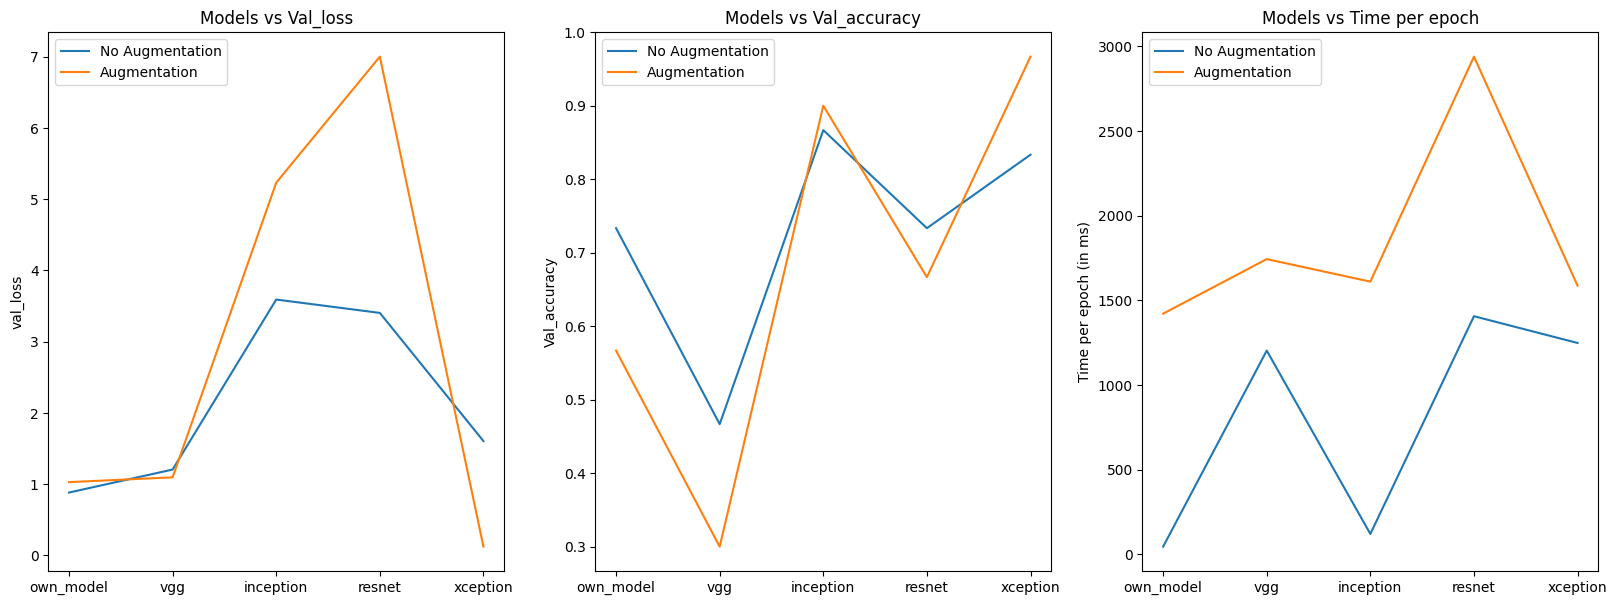

In [84]:
plt.figure(figsize=(20,7))

plt.subplot(1,3,1)
plt.plot(models.model, models.val_loss)
plt.plot(models.model, models.val_loss_aug)
plt.legend(['No Augmentation', 'Augmentation'])
plt.ylabel('val_loss')
plt.title('Models vs Val_loss');

plt.subplot(1,3,2)
plt.plot(models.model, models.val_acc)
plt.plot(models.model, models.val_acc_aug)
plt.legend(['No Augmentation', 'Augmentation'])
plt.ylabel('Val_accuracy')
plt.title('Models vs Val_accuracy')

plt.subplot(1,3,3)
plt.plot(models.model, models.time_ms)
plt.plot(models.model, models.time_ms_aug)
plt.legend(['No Augmentation', 'Augmentation'])
plt.ylabel('Time per epoch (in ms)')
plt.title('Models vs Time per epoch');

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Loading Best Model</h1>

In [47]:
own_model.load_weights('ownCNN_aug.weights.best.hdf5')

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Visualising Kernels</h1>

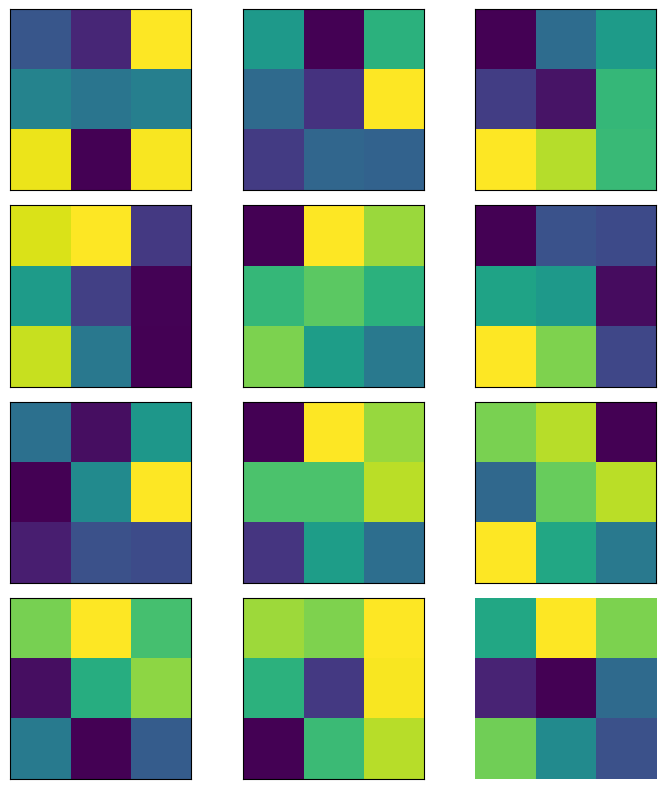

In [49]:
fig, ax= plt.subplots(4,3, figsize=(8,8))

for i, ax in zip(range(12), ax.flatten()):

  conv1=own_model.layers[0]
  weights1 = conv1.get_weights()
  kernels1 = weights1[0]
  kernel1_1 = kernels1[:,:,0,i]
  ax.imshow(kernel1_1)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.tight_layout()
  plt.axis('off');

Lets understand what features these kernel extract? What these kernels see?

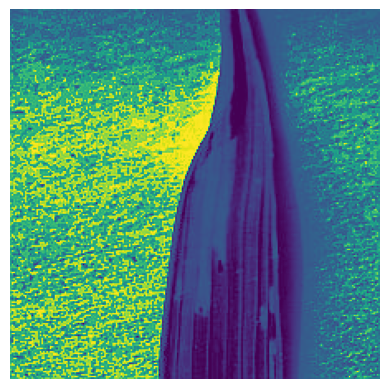

In [50]:
image = tf.keras.utils.load_img('data_rice_leaf_diseases/Bacterial_leaf_blight/bacterial_leaf_blight (6).JPG', target_size=input_shape_2D)
input_arr = tf.keras.utils.img_to_array(image)/255
image = input_arr[:, :, 1]
plt.imshow(image)
plt.axis('off');

In [51]:
import numpy as np

def convolution(image, kernel):
    # Get the size of the kernel
    kernel_size = kernel.shape[0]

    # Calculate the size of the output image
    output_size = image.shape[0] - kernel_size + 1

    # Initialize the output image
    output_image = np.zeros((output_size, output_size))

    # Pad the image with zeros
    padded_image = np.pad(image, ((kernel_size-1)//2, (kernel_size-1)//2), 'constant')

    # Apply the convolution operation
    for ii in range(output_size):
        for jj in range(output_size):
            window = padded_image[ii:ii+kernel_size, jj:jj+kernel_size]
            output_image[ii, jj] = np.sum(window * kernel)

    return output_image


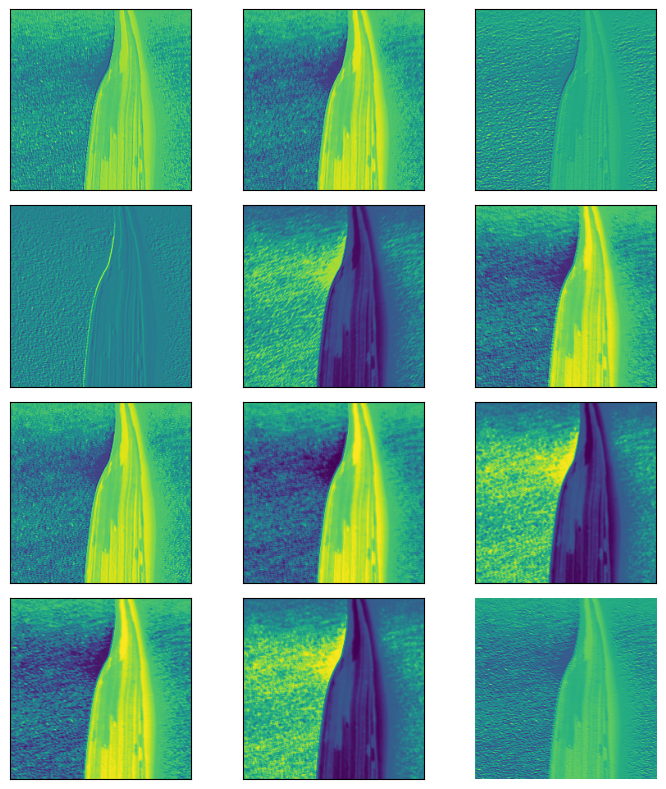

In [53]:
fig, ax= plt.subplots(4,3, figsize=(8,8))

for i, ax in zip(range(12), ax.flatten()):

  conv1=own_model.layers[0]
  weights1 = conv1.get_weights()
  kernels1 = weights1[0]
  kernel1_1 = kernels1[:,:,0,i]

  output=convolution(image, kernel1_1)

  ax.imshow(output)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.tight_layout()
  plt.axis('off');


<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Visualising Prediction</h1>


In [55]:
# get predictions on the test set
y_hat = own_model.predict(X_test)

# define text labels
labels = data_ds.class_names

15/15 [==============================] - 1s 32ms/step


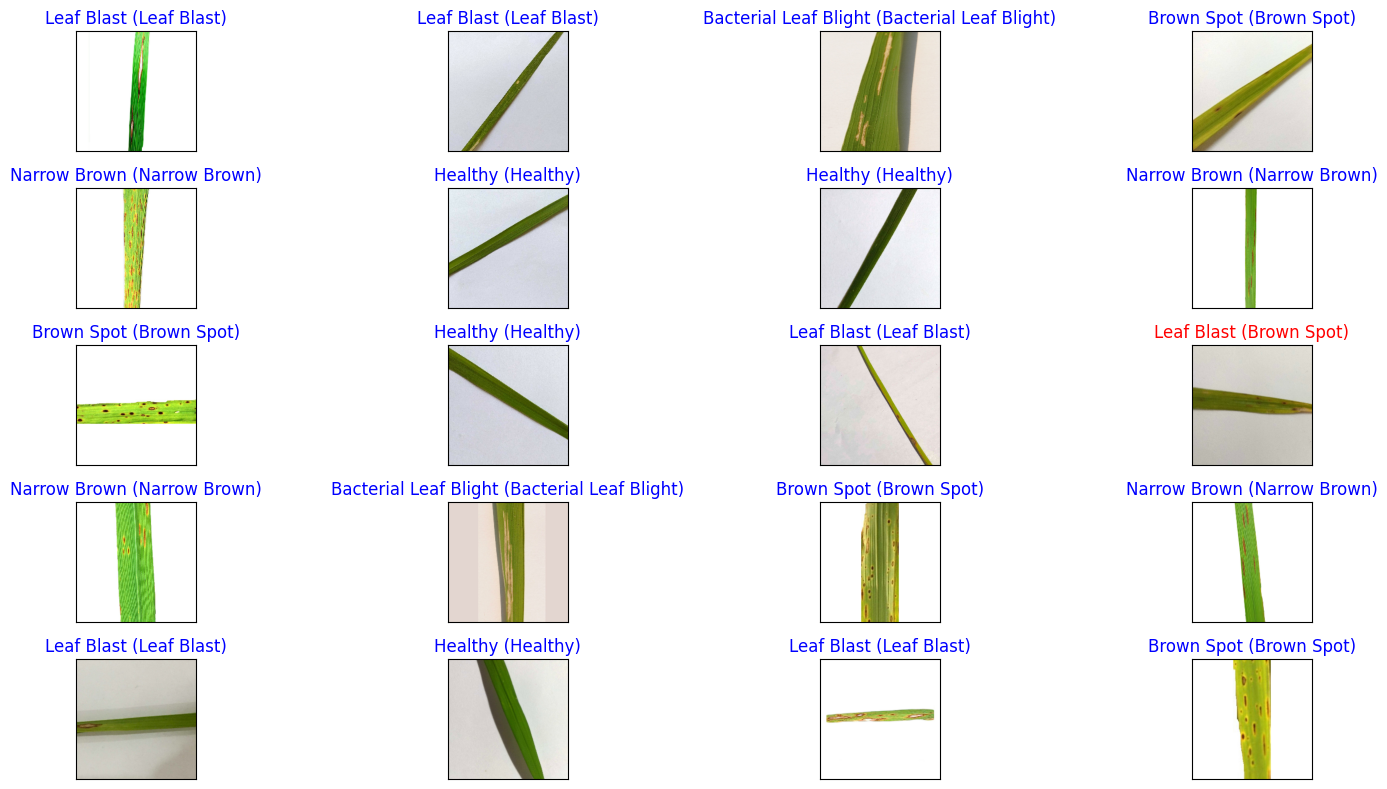

In [60]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=20, replace=False)):
    ax = fig.add_subplot(5, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "red"))
    plt.tight_layout()